### Configure environment

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,ashusri_0000051121
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


### Define configuration for this experiment

In [2]:
slice_name="bbr-trace-validation-" + fablib.get_bastion_username()
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)
     

#slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


In [3]:
n_senders = 10
n_receivers = 1

In [4]:
exp_requires = {'core': (n_senders+n_receivers)*4 + 4, 'nic': (n_senders + n_receivers + 1)*1}
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_requires['core']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_requires['nic'])  ):
        break

fablib.show_site(site_name)

Name,PRIN
State,Active
Address,"151, Forrestal Road, Plainsboro Township, Middlesex County, New Jersey, 08537"
Location,"(40.34612015, -74.61607299655245)"
PTP Capable,True
Hosts,3
CPUs,6
Cores Available,295
Cores Capacity,384
Cores Allocated,89
RAM Available,1026


'<pandas.io.formats.style.Styler object at 0x7a3ec4179030>'

In [4]:
# this cell sets up the hosts
slice.add_node(name='router', site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_22')

sender_names = ["sender-"+str(i) for i in range(n_senders)]
for n in sender_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_22')  

receiver_names = ["receiver-"+str(i) for i in range(n_receivers)]
for n in receiver_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_22')  



In [5]:
# this cell sets up the network links
nets = [
    {"name": "link-sender",    "nodes": sender_names,  "idx": 0},
    {"name": "link-receiver",  "nodes": receiver_names, "idx": 1}
]

router_iface = []
router_iface.append(slice.get_node('router').add_component(model="NIC_Basic", name='link-sender').get_interfaces()[0])
router_iface.append(slice.get_node('router').add_component(model="NIC_Basic", name='link-receiver').get_interfaces()[0])
print(router_iface)



[<fabrictestbed_extensions.fablib.interface.Interface object at 0x7f5081fb5de0>, <fabrictestbed_extensions.fablib.interface.Interface object at 0x7f5081fb7340>]


In [6]:
for n in nets:
    ifaces = [slice.get_node(node).add_component(model="NIC_Basic", name=n["name"]).get_interfaces()[0] for node in n['nodes'] ] + [router_iface[n["idx"]]]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)


In [7]:
slice.submit(wait_timeout=5000)


Retry: 18, Time: 1006 sec


ID,c5087ece-468d-47ad-9abf-f345ae5b2eb3
Name,bbr-trace-validation-ashusri_0000051121
Lease Expiration (UTC),2024-05-02 20:03:50 +0000
Lease Start (UTC),2024-05-01 20:03:52 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
f437357e-bfb0-4562-9ff8-51add9dc46c3,receiver-0,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe53:a83f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe53:a83f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
afe65210-14e4-46ba-bd72-8c3c55e772e5,router,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe73:27e2,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe73:27e2,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
d3645788-6890-4574-8be5-4460e5a45a2a,sender-0,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe67:38cb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe67:38cb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
5f2861fd-92d7-4d66-856c-6303a527c797,sender-1,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feb4:bdbb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feb4:bdbb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
d5fea363-911b-451a-831a-417fb43808f3,sender-2,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feaa:b754,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feaa:b754,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2c71e772-7783-4bf9-9db5-934e5ca143be,sender-3,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe87:6044,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe87:6044,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2aa35e89-8727-4b99-b053-9980f9a425f5,sender-4,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fede:283c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fede:283c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
83e4da5d-c814-4146-8371-ede7463cf412,sender-5,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feab:b3eb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feab:b3eb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c951f549-d1bf-417c-8bc3-3c5e13f40337,sender-6,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fec2:5140,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fec2:5140,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
403e7751-e99f-49f5-98a9-eb7f3df53e35,sender-7,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe29:dd98,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe29:dd98,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric

ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
4f86c3b6-1acb-40d8-8db0-b0c9d8726af5,link-receiver,L2,L2Bridge,RUTG,None,None,Active,
26a6f15e-fb75-4da0-8404-886993503338,link-sender,L2,L2Bridge,RUTG,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
router-link-sender-p1,p1,router,link-sender,100,config,,1E:9D:E1:A5:19:D9,enp7s0,enp7s0,None,4
router-link-receiver-p1,p1,router,link-receiver,100,config,,1E:E9:8A:1A:86:FC,enp8s0,enp8s0,None,4
sender-0-link-sender-p1,p1,sender-0,link-sender,100,config,,22:5B:A5:D0:3E:3D,enp7s0,enp7s0,None,4
sender-1-link-sender-p1,p1,sender-1,link-sender,100,config,,26:86:A8:9C:1F:3A,enp7s0,enp7s0,None,4
sender-2-link-sender-p1,p1,sender-2,link-sender,100,config,,26:D2:8B:10:33:4A,enp7s0,enp7s0,None,4
sender-3-link-sender-p1,p1,sender-3,link-sender,100,config,,2E:7A:59:B3:AA:30,enp7s0,enp7s0,None,4
sender-4-link-sender-p1,p1,sender-4,link-sender,100,config,,2E:80:D8:C5:19:03,enp7s0,enp7s0,None,4
sender-5-link-sender-p1,p1,sender-5,link-sender,100,config,,2E:A6:FE:7A:07:1F,enp7s0,enp7s0,None,4
sender-6-link-sender-p1,p1,sender-6,link-sender,100,config,,2E:12:2D:BD:CE:78,enp7s0,enp7s0,None,4
sender-7-link-sender-p1,p1,sender-7,link-sender,100,config,,32:07:50:38:43:8A,enp7s0,enp7s0,None,4



Time to print interfaces 1024 seconds


'c5087ece-468d-47ad-9abf-f345ae5b2eb3'

In [5]:
slice.get_state()

'StableOK'

In [6]:
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

## Install BBRv2 kernel

In [64]:
pkg_list = ['linux-headers-5.13.12_5.13.12-2_amd64.deb',
            'linux-libc-dev_5.13.12-2_amd64.deb',
            'linux-image-5.13.12_5.13.12-2_amd64.deb']

cmd_BBRv2 ="""sudo grub-set-default "Advanced options for Ubuntu>Ubuntu, with Linux 5.13.12"
sudo grub-mkconfig -o /boot/grub/grub.cfg
sudo sed -i 's/^GRUB_DEFAULT=.*/GRUB_DEFAULT=saved/' /etc/default/grub
sudo update-grub
sudo reboot"""

for n in sender_nodes:
    for pkg in pkg_list:
        n.execute("wget https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/{packet}".format(packet=pkg))
    n.execute("sudo dpkg -i  *.deb")
    n.execute(cmd_BBRv2)


 --2024-05-01 22:39:10--  https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/linux-headers-5.13.12_5.13.12-2_amd64.deb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8347652 (8.0M) [application/octet-stream]
Saving to: ‘linux-headers-5.13.12_5.13.12-2_amd64.deb.1’

     0K .......... .......... .......... .......... ..........  0% 22.5M 0s
    50K .......... .......... .......... .......... ..........  1% 22.8M 0s
   100K .......... .......... .......... .......... ..........  1% 22.9M 0s
   150K .......... .......... .......... .......... ..........  2%  143M 0s
   200K .......... .......... .......... .......... ..........  3% 97.1M 0s
   250K .......... .......... .......... .......... ..........  3% 37.3M 0s
   300K ......

In [31]:
pkg_list = ['linux-headers-5.13.12_5.13.12-2_amd64.deb',
            'linux-libc-dev_5.13.12-2_amd64.deb',
            'linux-image-5.13.12_5.13.12-2_amd64.deb']

cmd_BBRv2 ="""sudo grub-set-default "Advanced options for Ubuntu>Ubuntu, with Linux 5.13.12"
sudo grub-mkconfig -o /boot/grub/grub.cfg
sudo sed -i 's/^GRUB_DEFAULT=.*/GRUB_DEFAULT=saved/' /etc/default/grub
sudo update-grub
sudo reboot"""

for n in receiver_nodes:
    for pkg in pkg_list:
        n.execute("wget https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/{packet}".format(packet=pkg))
    n.execute("sudo dpkg -i  *.deb")
    n.execute(cmd_BBRv2)

 --2024-05-06 16:11:31--  https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/linux-headers-5.13.12_5.13.12-2_amd64.deb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8347652 (8.0M) [application/octet-stream]
Saving to: ‘linux-headers-5.13.12_5.13.12-2_amd64.deb’

     0K .......... .......... .......... .......... ..........  0% 24.7M 0s
    50K .......... .......... .......... .......... ..........  1% 25.2M 0s
   100K .......... .......... .......... .......... ..........  1% 21.5M 0s
   150K .......... .......... .......... .......... ..........  2% 30.7M 0s
   200K .......... .......... .......... .......... ..........  3% 85.4M 0s
   250K .......... .......... .......... .......... ..........  3%  175M 0s
   300K ........

In [32]:
for n in sender_nodes:
    n.execute("uname -a")

for n in receiver_nodes:
    n.execute("uname -a")

Linux sender-0 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-1 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-2 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-3 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-4 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-5 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-6 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-7 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-8 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-9 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux receiver-0 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


In [10]:
for n in sender_nodes:
    n.execute("sudo modprobe tcp_bbr2")

## Configure resources

In [11]:
slice = fablib.get_slice(name=slice_name)

Bring up all of the network interfaces:

In [37]:
for iface in slice.get_interfaces():
    iface.ip_link_up()

Assign addresses to router interfaces and enable forwarding:

In [24]:
from ipaddress import ip_address, IPv4Address, IPv4Network

if_sender = slice.get_interface('router-link-sender-p1')
if_sender.ip_addr_add(addr="10.10.1.1", subnet=IPv4Network("10.10.1.0/24"))
if_receive = slice.get_interface('router-link-receiver-p1')
if_receive.ip_addr_add(addr="10.10.2.1", subnet=IPv4Network("10.10.2.0/24"))

slice.get_node(name='router').execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1


('net.ipv4.ip_forward = 1\n', '')

Assign addresses to host (sender and receiver) interfaces and set up routes:

In [38]:
for i in range(n_senders):
    if_name = slice.get_interface('sender-' + str(i) + '-link-sender-p1')
    if_name.ip_addr_add(addr="10.10.1.1" + str(i) , subnet=IPv4Network("10.10.1.0/24"))
    slice.get_node(name='sender-' + str(i)).ip_route_add(subnet=IPv4Network("10.10.2.0/24"), gateway="10.10.1.1")
    
for i in range(n_receivers):
    if_name = slice.get_interface('receiver-' + str(i) + '-link-receiver-p1')
    if_name.ip_addr_add(addr="10.10.2.1" + str(i) , subnet=IPv4Network("10.10.2.0/24"))
    slice.get_node(name='receiver-' + str(i)).ip_route_add(subnet=IPv4Network("10.10.1.0/24"), gateway="10.10.2.1")

In [26]:
# turn off segmentation offload on interfaces
for iface in slice.get_interfaces():
    iface_name = iface.get_device_name()
    n = iface.get_node()
    offloads = ["gro", "lro", "gso", "tso"]
    for offload in offloads:
        n.execute("sudo ethtool -K %s %s off" % (iface_name, offload))

Also install `iperf3` on sender and receiver hosts:

In [8]:
sender_nodes = [slice.get_node(name='sender-' + str(i))  for i in range(n_senders)]
receiver_nodes = [slice.get_node(name='receiver-' + str(i))  for i in range(n_receivers)]

In [24]:
from ipaddress import ip_address, IPv6Address
for n in sender_nodes:
    n.execute("sudo apt update; sudo apt -y install iperf3; sudo apt -y install python3; sudo modprobe tcp_bbr")
    n.execute_thread("sudo modprobe tcp_bbr")
              
for n in receiver_nodes:
    n.execute_thread("sudo apt update; sudo apt -y install iperf3")
    


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
 

 Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists...
Building dependency tree...
Reading state information...
99 packages can be upgraded. Run 'apt list --upgradable' to see them.
 

 Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libiperf0 libsctp1
Suggested packages:
  lksctp-tools
The following NEW packages will be installed:
  iperf3 libiperf0 libsctp1
0 upgraded, 3 newly installed, 0 to remove and 99 not upgraded.
Need to get 106 kB of archives.
After this operation, 346 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 libsctp1 amd64 1.0.19+dfsg-1build1 [9370 B]
Get:2 http://no

In [98]:
for n in sender_nodes:
    n.execute("sudo apt -y install python3")

Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Bui

In [12]:
for n in sender_nodes:
    n.execute("iperf3 -version")

iperf 3.9 (cJSON 1.7.13)
Linux sender-0 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication
iperf 3.9 (cJSON 1.7.13)
Linux sender-1 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication
iperf 3.9 (cJSON 1.7.13)
Linux sender-2 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication
iperf 3.9 (cJSON 1.7.13)
Linux sender-3 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication


In [26]:
for n in sender_nodes:
    n.execute("sudo apt-get update; sudo apt-get install -y python3-pip ethtool netcat moreutils ",quiet=True)
    n.execute("sudo python3 -m pip install scikit-learn numpy pandas matplotlib seaborn", quiet=True)
    
for n in receiver_nodes:
    n.execute("sudo apt-get update; sudo apt-get install -y python3-pip ethtool netcat moreutils ",quiet=True)
    n.execute("sudo python3 -m pip install scikit-learn numpy pandas matplotlib seaborn", quiet=True)

## Draw the network topology 

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [12]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
all_nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

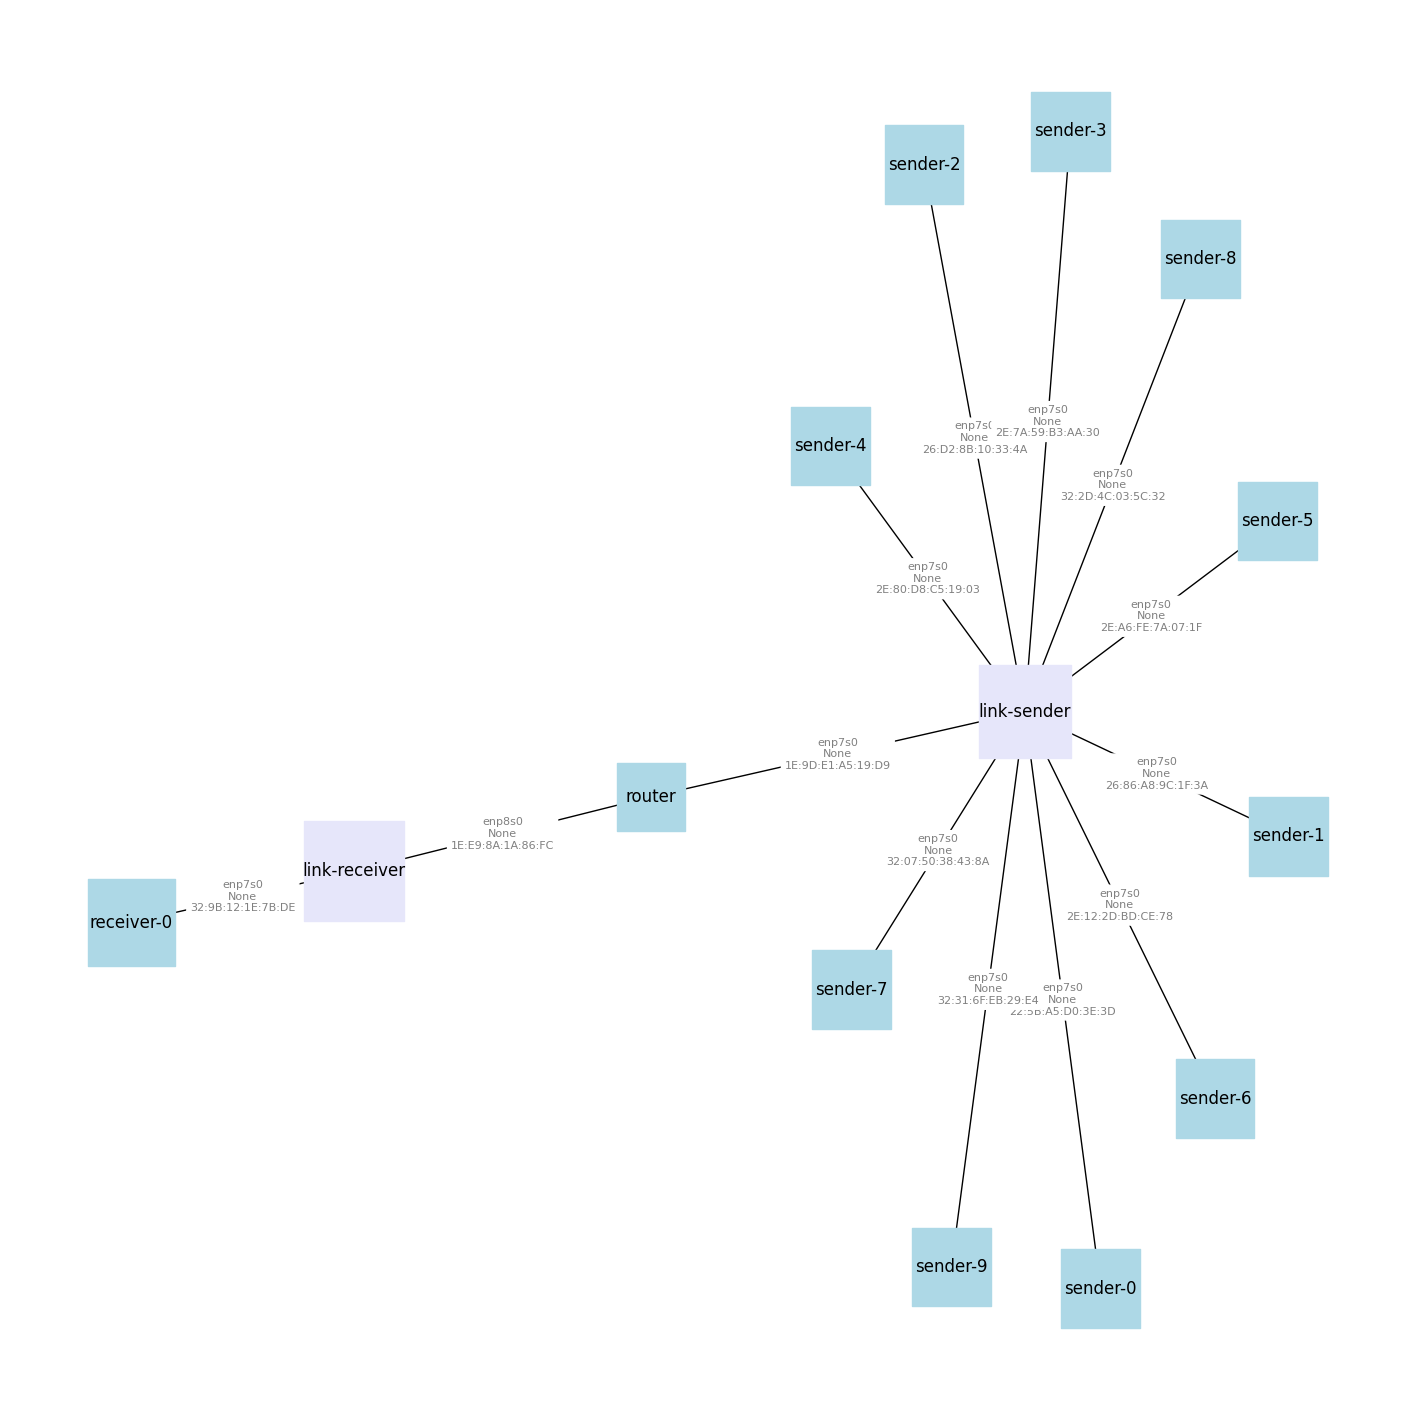

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(all_nodes),len(all_nodes)))
G = nx.Graph()
G.add_nodes_from(all_nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in all_nodes], 
        node_size=[len(n[0])*400 for n in all_nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);
     

## Extend your slice

In [14]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

## Log in to hosts

In [73]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe73:27e2
sender-0,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe67:38cb
sender-1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feb4:bdbb
sender-2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feaa:b754
sender-3,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe87:6044
sender-4,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fede:283c
sender-5,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feab:b3eb
sender-6,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fec2:5140
sender-7,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe29:dd98


In [15]:
sender_nodes = [slice.get_node(name='sender-' + str(i))  for i in range(n_senders)]
receiver_nodes = [slice.get_node(name='receiver-' + str(i))  for i in range(n_receivers)]
router_node = slice.get_node(name='router')
router_ingress_iface = router_node.get_interface(network_name = "link-sender")
router_egress_iface  = router_node.get_interface(network_name = "link-receiver")
router_egress_name = router_egress_iface.get_device_name()

## Configure queues

In [23]:
import math

btl_rate = 100 # in Mbps

btl_link_delay = 10 # in ms

limit = math.ceil((7*btl_rate * btl_link_delay * 10^3)/8)

# Set up delay on receiver interface
for n in receiver_nodes:
    receiver_inf = n.get_interface(network_name="link-receiver")
    receiver_inf_name = receiver_inf.get_device_name()
    n.execute(f"sudo tc qdisc del dev {receiver_inf_name} root netem")
    n.execute(f"sudo tc qdisc add dev {receiver_inf_name} root netem delay {btl_link_delay}ms limit 1000000")


print(f"sudo tc class add dev {router_egress_name} parent 1: classid 1:3 htb rate {btl_rate}mbit")
print(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: bfifo limit {limit}")

# Set up router queue
router_node.execute(f"sudo tc qdisc del dev {router_egress_name} root")
router_node.execute(f"sudo tc qdisc replace dev {router_egress_name} root handle 1: htb default 3")
router_node.execute(f"sudo tc class add dev {router_egress_name} parent 1: classid 1:3 htb rate {btl_rate}mbit")
router_node.execute(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: bfifo limit {limit}")

sudo tc class add dev enp8s0 parent 1: classid 1:3 htb rate 100mbit
sudo tc qdisc add dev enp8s0 parent 1:3 handle 3: bfifo limit 8751


('', '')

In [22]:
import random
for n in sender_nodes:
    sender_inf = n.get_interface(network_name="link-sender")
    sender_inf_name = sender_inf.get_device_name()
    
    sender_delay = round(random.uniform(20,30),1)
    
    print(sender_delay)
    
    n.execute(f"sudo tc qdisc del dev {sender_inf_name} root")
    n.execute(f"sudo tc qdisc add dev {sender_inf_name} root netem delay {sender_delay}ms limit 1000000")
    # n.execute(f"sudo tc qdisc add dev {sender_inf_name} parent 1:1 handle 10: fq pacing")

23.4
20.6
20.3
21.1
24.3
27.2
27.9
25.3
24.2
27.3


### Execute Experiment

In [55]:
receiver_nodes[0].execute("rm -r scherrer-exp-aggregate")
router_node.execute("rm -r scherrer-exp-aggregate")

('', '')

In [40]:
for n in sender_nodes:
    n.execute("sudo modprobe tcp_bbr")
    n.execute("sudo modprobe tcp_bbr2")
    
for n in receiver_nodes:
    n.execute("sudo modprobe tcp_bbr")
    n.execute("sudo modprobe tcp_bbr2")

In [56]:
# Set experimental parameters : generate full factorial experiment
import itertools
exp_factors = {
    'rate': [100],
    'btl_delay': [10],
    'cca': ["bbr-bbr","bbr-bbr2","bbr-cubic","bbr-reno","bbr2-bbr2","bbr2-cubic","bbr2-reno"],
    'test_duration': [9],
    'flows': [1],
    'interval': [0.1],
    'omit': [4],
    'aqm': ['FIFO'],
    'buffer_factor' : [1,2,3,4,5,6,7],
    'trial': [1]
}

factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]

In [57]:
import os
import csv

os.remove('experiment_results.csv')
# Create a list of header fields for the CSV file
fields = ['rate', 'btl_delay', 'cca', 'test_duration', 'flows', 'interval', 'omit', 'aqm', 'buffer_factor', 'trial', 'jfi', 'loss_percentage', 'utilization', 'buffer_occupancy']

# Write the header to the CSV file
with open('experiment_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()

In [ ]:
import time
import os
import csv
import random
import math
import itertools

router_script="rm queue.txt; start_time=$(date +%s); while true; do tc -p -s -d qdisc show dev {iface} | tr -d \'\n\' | ts '%.s' | tee -a queue.txt; echo \"\" | tee -a queue.txt; current_time=$(date +%s); elapsed_time=$((current_time - start_time));  if [ $elapsed_time -ge {duration} ]; then break; fi; sleep 0.01; done;"

def create_directory(directory_name):
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    else:
        print(f"Directory '{directory_name}' already exists.")
        
        
def setup_experiment(exp):
    directory_name = "scherrer-exp-aggregate"
    create_directory(directory_name)

    data_dir = os.path.join(os.getcwd(), directory_name)
    iequal_file_out = os.path.join(data_dir, f'ieq_{"_".join(str(v) for v in exp.values())}.csv')

    if os.path.exists(iequal_file_out):
        print("Already have relevant files, skipping")
        return

    print("Running experiment to generate packet loss files for exp:", iequal_file_out)
    
    limit = math.ceil(((exp['buffer_factor']+1)*exp['rate'] * exp['btl_delay'] * 10^3)/8)

    # Set up router queue
    
    router_node.execute(f"sudo tc qdisc del dev {router_egress_name} root")
    router_node.execute(f"sudo tc qdisc replace dev {router_egress_name} root handle 1: htb default 3")
    router_node.execute(f"sudo tc class add dev {router_egress_name} parent 1: classid 1:3 htb rate {exp['rate']}mbit")
    
    if exp['aqm'] == 'FIFO':
        router_node.execute(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: bfifo limit {limit}")
    if exp['aqm'] == 'RED':
        router_node.execute(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: red limit {limit} avpkt 1000")

    # Remove existing result files from hosts
        
    # Set up delay on receiver interface
    for n in receiver_nodes:
        receiver_inf = n.get_interface(network_name="link-receiver")
        receiver_inf_name = receiver_inf.get_device_name()
        n.execute(f"sudo tc qdisc del dev {receiver_inf_name} root netem")
        n.execute(f"sudo tc qdisc add dev {receiver_inf_name} root netem delay {exp['btl_delay']}ms limit 1000000")
        
        
    
        
def add_sender_link_delays(sender_nodes):
    for n in sender_nodes:
        sender_inf = n.get_interface(network_name="link-sender")
        sender_inf_name = sender_inf.get_device_name()

        sender_delay = round(random.uniform(20,30),1)

        #print(sender_delay)

        n.execute(f"sudo tc qdisc del dev {sender_inf_name} root")
        n.execute(f"sudo tc qdisc add dev {sender_inf_name} root netem delay {sender_delay}ms limit 1000000")
        # n.execute(f"sudo tc qdisc add dev {sender_inf_name} parent 1:1 handle 10: fq pacing")

        
def start_servers(sender_nodes, base_port):  
    for i,s in enumerate(sender_nodes):
        s.execute("sudo killall iperf3")
        
        server_port = base_port + i
        s.execute(f"iperf3 -s -D -p {server_port}")

def start_clients(receiver_node, sender_nodes, exp, base_port):
    print("Start parallel clients on the senders")
    
    r = receiver_node
    r.execute("rm *.json")
    r.execute("sudo killall iperf3")
    
    #print(router_script.format(iface=router_egress_name, duration=exp["test_duration"]))
    
    
    for i, n in enumerate(sender_nodes):
        
        server_port = base_port + i
        server_id = 10 + i
        
        cca = exp['cca'].split("-")[0] if i < 5 else exp['cca'].split("-")[1]
        
        #print(f'sleep 1; iperf3 -c 10.10.2.10 -t {exp["test_duration"]} -P {exp["flows"]} -C {cca} -p {server_port} -O {exp["omit"]} -i {exp["interval"]} -J > flow-{i}-result.json')

        r.execute_thread(f'sleep 1; iperf3 -c 10.10.1.{server_id} -t {exp["test_duration"]} -P {exp["flows"]} -C {cca} -p {server_port} -O {exp["omit"]} -i {exp["interval"]} -R -J > flow-{i}-result.json')
        
    router_node.execute_thread(router_script.format(iface=router_egress_name, duration=exp["test_duration"]))
    
def copy_files_to_dir(exp_dir):   
    
    receiver_nodes[0].execute(f'mkdir -p {exp_dir} && mv *.json {exp_dir}/')
    
    router_node.execute(f'mkdir -p {exp_dir} && mv *.txt {exp_dir}/')
    
    router_node.execute(f'mkdir -p {exp_dir} && mv *.csv {exp_dir}/')
        
def compute_jfi(throughput):

    #mean_throughput = sum(throughput) / len(throughput)

    denominator = sum(t ** 2 for t in throughput)
    
    numerator = (sum(throughput)) ** 2
    
    jfi = (numerator / (len(throughput) * denominator))
    
    return jfi
        
def process_data(receiver_node, sender_nodes, exp):
    
    r = receiver_node
    
    sum_tput = 0
    
    pkt_loss = 0
    
    throughput = []
    for i,s in enumerate(sender_nodes):
        
        sum_received, stderr = r.execute(f'echo $(jq \'.end.sum_received.bits_per_second\' \"flow-{i}-result.json\")')
        
        throughput.append(float(sum_received))
        
        retrans, stderr = r.execute(f'echo $(jq \'.end.streams[].sender.retransmits\' \"flow-{i}-result.json\")')
        
        retrans = float(retrans)
        pkt_loss = pkt_loss + retrans
        
    loss_percentage = ((pkt_loss * 1500 * 8) * 100) / (sum(throughput) * exp['test_duration'])
    
    utilization = (sum(throughput) * 100)/ (exp['rate'] * 1000000)
        
    jfi = compute_jfi(throughput)
    
    
    router_node.execute("cat queue.txt | awk '{{print $1\",\"$24$30\",\"$31}}' | tr -d 'b' | tr -d 'p' | sed 's/K/000/' | sed 's/M/000000/' > queue.csv")
    
    mean_backlog, stderr = router_node.execute("echo $(awk -F ',' '{ total += $3; count++ } END { print total/count }' \"queue.csv\")")
    
    limit = math.ceil(((exp['buffer_factor']+1)*exp['rate'] * exp['btl_delay'] * 10^3)/8)
    
    buffer_occupancy = (float(mean_backlog) * 100)/limit
    
    
    print("Jain's fairness index = ", jfi)
    
    print("Loss percentage = ", loss_percentage)
    
    print("Utilization = ", utilization)
    
    print("Buffer occupancy percentage = ", buffer_occupancy)
    
    row = {**exp, 'jfi': jfi, 'loss_percentage': loss_percentage, 'utilization': utilization, 'buffer_occupancy': buffer_occupancy}
    with open('experiment_results.csv', mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fields)
        writer.writerow(row)

        
    
for exp in exp_lists:
    
    setup_experiment(exp)
    
    add_sender_link_delays(sender_nodes)
    
    base_port = 5201

    # Start servers
    start_servers(sender_nodes, base_port)
    
    # Start clients
    start_clients(receiver_nodes[0], sender_nodes, exp, base_port)
    
    print("Done")
    
    time.sleep(exp['test_duration'] + 10)
    
    
    process_data(receiver_nodes[0], sender_nodes, exp)
    
    
    # Copy files to directory
    exp_dir = f"scherrer-exp-aggregate/{'_'.join(str(v) for v in exp.values())}"
    copy_files_to_dir(exp_dir)



Directory 'scherrer-exp-aggregate' already exists.
Running experiment to generate packet loss files for exp: /home/fabric/work/bbr_imc_2022/scherrer-exp-aggregate/ieq_100_10_bbr-bbr_9_1_0.1_4_FIFO_1_1.csv
 Error: Invalid qdisc name.
 Start parallel clients on the senders
 rm: cannot remove '*.json': No such file or directory
  iperf3: no process found
 Done
1490474.501058389
265
4640008.23106264
845
8143521.235586444
1161
9295508.181770505
1422
18186752.69273115
2045
2314216.520911694
410
1374622.6005349508
269
4507476.63354101
764
2459665.7804827616
397
5568048.853387615
892
182.539
Jain's fairness index =  0.5878683297979582
Loss percentage =  19.477881732623718
Utilization =  57.98029523106716
Buffer occupancy percentage =  7.298640543782486
Directory 'scherrer-exp-aggregate' already exists.
Running experiment to generate packet loss files for exp: /home/fabric/work/bbr_imc_2022/scherrer-exp-aggregate/ieq_100_10_bbr-bbr_9_1_0.1_4_FIFO_2_1.csv
Start parallel clients on the senders
 r

In [59]:
r = receiver_nodes[0]

#out = r.execute("echo $(jq '.end.sum_received.bits_per_second' \"flow-0-result.json\")")

i = 0

retrans, stderr = r.execute(f'echo $(jq \'.end.streams[].sender.retransmits\' \"flow-{i}-result.json\")')



1629


In [57]:
print(sum_received)

11640682.038435273



In [ ]:

# nodes and instances

tx_1_node = slice.get_node(name="tx_1")
rx_1_node = slice.get_node(name="rx_1")
delay_node = slice.get_node(name="delay")
router_node = slice.get_node(name="router")
# interfaces

tx_1_egress_iface  = tx_1_node.get_interface(network_name = "net-tx")

delay_ingress_tx_iface  = delay_node.get_interface(network_name = "net-tx")
delay_egress_iface  = delay_node.get_interface(network_name = "net-delay-router")
delay_ingress_tx_name = delay_ingress_tx_iface.get_device_name()
delay_egress_name = delay_egress_iface.get_device_name()

router_ingress_iface  = router_node.get_interface(network_name = "net-delay-router")
router_egress_iface  = router_node.get_interface(network_name = "net-rx")
router_egress_name  = router_egress_iface.get_device_name()

rx_1_ingress_iface  = rx_1_node.get_interface(network_name = "net-rx")

In [ ]:
# generate full factorial experiment
import itertools

exp_factors = {
    'n_bdp': [0.5, 2, 5, 10],  # n x bandwidth delay product
    'btl_capacity': [100, 1000], #in Mbps #'btl_capacity': [100, 1000]
    'base_rtt': [5, 10, 50, 100], # in ms #'base_rtt': [5, 10, 50, 100],
    'aqm': ['FIFO', 'single_queue_FQ', 'Codel', 'FQ', 'FQ_Codel', 'DualPI2'],
    'ecn_threshold': [1, 5, 20], # in ms #'ecn_threshold': [1, 5, 20]
    'ecn_fallback': [0, 1],  #fallback algorithm, TCP Prague falls back to classic TCP when it detects single queue classic ECN bottleneck # 0: OFF, 1: ON  #'ecn_fallback': [0, 1]
    'rx_L4S_ecn': [0,1,3],  # 0: noecn, 1: ecn, 3: accecn #'rx_L4S_ecn': [0, 1, 3]
    'rx_legacy_ecn': [0,1],  # 0: noecn, 1: ecn #'rx_legacy_ecn': [0, 1]
    'cc_tx_L4S': ["prague"],
    'cc_tx_legacy': ["cubic", "bbr"],
    'trial': [1,2,3,4,5] #'trial': [1, 2, 3, 4, 5]
}

flow_number_tx_L4S=1 #number of tx_L4S flows
flow_number_tx_legacy=1 #number of tx_legacy flows

factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))

exp_lists = []

seen_combinations = set()

# Removing ECN factor from FIFO bottleneck because it does not support ECN
# Removing the cases where ECN Threshold is less than or equal to the buffer size in time, these cases are not meaningful in practice

for factor_l in factor_lists:
    temp_dict = dict(zip(factor_names, factor_l))
    if temp_dict['n_bdp'] * temp_dict['base_rtt'] >= temp_dict['ecn_threshold']:
        if temp_dict['aqm'] == 'FIFO':
            del temp_dict['ecn_threshold']
        # Convert dict to a frozenset for set operations
        fs = frozenset(temp_dict.items())
    
        if fs not in seen_combinations:
            seen_combinations.add(fs)
            exp_lists.append(temp_dict)

data_dir_tx_L4S = slice_name + 'singlebottleneck'+"-tx_L4S"
data_dir_tx_legacy = slice_name + 'singlebottleneck'+"-tx_legacy"

print("Number of experiments:",len(exp_lists))

configure 100 Mbps bottleneck link with delay = 10ms

In [25]:
btl_capacity = 100

base_rtt = 10

n_bdp = 1
aqm = 'FIFO'

btl_limit  = int(1000*n_bdp*btl_capacity*base_rtt/8) # limit of the bottleneck, n_bdp x BDP in bytes 

print(btl_limit)

#aqm type selection
cmds_prefix = '''
    sudo tc qdisc del dev {iface} root
    sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
    sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
    '''.format(iface=router_egress_name, capacity=btl_capacity, buffer=btl_limit)

cmds_specific_initial = "sudo tc qdisc replace dev {iface} parent 1:3 handle 3: ".format(iface=router_egress_name)


cmds_specific = {
'FIFO': "bfifo limit {buffer}".format(buffer=btl_limit)}

cmds_aqm = {key: cmds_specific_initial + cmd for key, cmd in cmds_specific.items()}

router_node.execute(cmds_prefix)
router_node.execute(cmds_aqm[aqm])

125000
 Error: Cannot delete qdisc with handle of zero.
 

('', '')

In [ ]:
# run experiments
import time
d = 60 #duration in seconds

em = [delay_ingress_tx_name, delay_egress_name]

for exp in exp_lists:

    # check if we already ran this experiment
    # (allow stop/resume)
    name_tx_L4S="%s_%0.1f_%d_%d_%s_%s_%d_%d_%d_%d" % (exp['cc_tx_L4S'],exp['n_bdp'], exp['btl_capacity'], exp['base_rtt'], exp['aqm'], str(exp.get('ecn_threshold', 'none')), exp['ecn_fallback'], exp['rx_L4S_ecn'], exp['rx_legacy_ecn'], exp['trial'])
    name_tx_legacy="%s_%0.1f_%d_%d_%s_%s_%d_%d_%d_%d" % (exp['cc_tx_legacy'],exp['n_bdp'], exp['btl_capacity'], exp['base_rtt'], exp['aqm'], str(exp.get('ecn_threshold', 'none')), exp['ecn_fallback'], exp['rx_L4S_ecn'], exp['rx_legacy_ecn'], exp['trial'])
    
    file_out_tx_L4S_json = name_tx_L4S+"-result.json"
    stdout_tx_L4S_json, stderr_tx_L4S_json = tx_L4S_node.execute("ls " + file_out_tx_L4S_json, quiet=True) 
    
    file_out_tx_legacy_json =name_tx_legacy+"-result.json"
    stdout_tx_legacy_json, stderr_tx_legacy_json = tx_legacy_node.execute("ls " + file_out_tx_legacy_json, quiet=True) 
    

    if len(stdout_tx_L4S_json) and len(stdout_tx_legacy_json):
        print("Already have " + name_tx_L4S + " and "+ name_tx_legacy + ", skipping")

    elif len(stderr_tx_L4S_json) or len(stderr_tx_legacy_json):
        print("Running experiment to generate " + name_tx_L4S + " and "+ name_tx_legacy) 
        
        
        tx_L4S_node.execute("sudo modprobe tcp_" + exp['cc_tx_L4S'])
        tx_L4S_node.execute("sudo sysctl -w net.ipv4.tcp_congestion_control=" + exp['cc_tx_L4S'])
        tx_L4S_node.execute("sudo sysctl -w net.ipv4.tcp_ecn=3") # it is assumed that the L4S sender uses AccECN
        
        tx_legacy_node.execute("sudo modprobe tcp_" + exp['cc_tx_legacy'])
        tx_legacy_node.execute("sudo sysctl -w net.ipv4.tcp_congestion_control=" + exp['cc_tx_legacy'])
        tx_legacy_node.execute("sudo sysctl -w net.ipv4.tcp_ecn=1") # it is assumed that the legacy sender uses Classic ECN
        
        # delay at emulator
        for e in em:
            cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=e, owd=exp['base_rtt']/2)
            delay_node.execute(cmds)
        
        # fixed values
        btl_limit    = int(1000*exp['n_bdp']*exp['btl_capacity']*exp['base_rtt']/8) # limit of the bottleneck, n_bdp x BDP in bytes 
        packet_number=int(btl_limit/1500)+1
        
        
        #ecn-fallback configuration
               
        commands = "echo {value} | sudo tee /sys/module/tcp_prague/parameters/prague_ecn_fallback".format(value=str(exp['ecn_fallback']))
        tx_L4S_node.execute(commands)
        
        #receiver ecn configuration
                
        rx_L4S_node.execute("sudo sysctl -w net.ipv4.tcp_ecn={ecn_type}".format(ecn_type=exp['rx_L4S_ecn']))
        rx_legacy_node.execute("sudo sysctl -w net.ipv4.tcp_ecn={ecn_type}".format(ecn_type=exp['rx_legacy_ecn']))
        
        #aqm type selection
        cmds_prefix = '''
            sudo tc qdisc del dev {iface} root
            sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
            sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
            '''.format(iface=router_egress_name, capacity=exp['btl_capacity'], buffer=btl_limit)
        
        cmds_specific_initial = "sudo tc qdisc replace dev {iface} parent 1:3 handle 3: ".format(iface=router_egress_name)
        
        cmds_specific = {
        'FIFO': "bfifo limit {buffer}".format(buffer=btl_limit),
        'single_queue_FQ': "fq limit {packet_limit} flow_limit {packet_limit} orphan_mask 0 ce_threshold {threshold}ms".format(packet_limit=packet_number, threshold=exp.get('ecn_threshold', 0)),
        'Codel': "codel limit {packet_limit} target {target}ms interval 100ms ecn ce_threshold {threshold}ms".format(packet_limit=packet_number, target=exp['base_rtt']*exp['n_bdp'], threshold=exp.get('ecn_threshold', 0)),
        'FQ': "fq limit {packet_limit} flow_limit {packet_limit} ce_threshold {threshold}ms".format(packet_limit=packet_number, threshold=exp.get('ecn_threshold', 0)),
        'FQ_Codel': "fq_codel limit {packet_limit} target {target}ms interval 100ms ecn ce_threshold {threshold}ms".format(packet_limit=packet_number, target=exp['base_rtt']*exp['n_bdp'], threshold=exp.get('ecn_threshold', 0)),
        'DualPI2': "dualpi2 target {threshold}ms".format(threshold=exp.get('ecn_threshold', 0))
        }

        cmds_aqm = {key: cmds_specific_initial + cmd for key, cmd in cmds_specific.items()}
        
        router_node.execute(cmds_prefix)
        router_node.execute(cmds_aqm[ exp['aqm'] ])
            
        rx_L4S_node.execute("killall iperf3")
        rx_legacy_node.execute("killall iperf3")
        

        #print("Starting experiment with {1} bdp {2} capacity {3} rtt {4} {5} thrshold {6} ecn_fallback {7} rx_L4S {8} rx_legacy for {duration} seconds".format(duration=d, 1=exp['n_bdp'], 2=exp['btl_capacity'], 3=exp['base_rtt'], 4=exp['aqm'], 5=exp['ecn_threshold'], 6= exp['ecn_fallback'], 7=exp['rx_L4S_ecn'], 8=exp['rx_legacy_ecn']))
        
        rx_L4S_node.execute("iperf3 -s -1 -p 4000 -D")
        rx_legacy_node.execute("iperf3 -s -1 -p 5000 -D")
        
        tx_L4S_node.execute_thread("sleep 1; iperf3 -c 10.0.5.100 -t {duration} -P {flows} -C {cc} -p 4000 -J > {flow}-result.json".format(flow =name_tx_L4S, duration=d, flows=flow_number_tx_L4S, cc=exp['cc_tx_L4S']))
        stdout, stderr = tx_legacy_node.execute("sleep 1; iperf3 -c 10.0.5.101 -t {duration} -P {flows} -C {cc} -p 5000 -J > {flow}-result.json".format(flow =name_tx_legacy, duration=d, flows=flow_number_tx_legacy, cc=exp['cc_tx_legacy']))
        time.sleep(3)  # time.sleep(1)
        
print("finished")

### Analysis of the results

In [ ]:
tx_L4S_node.execute('mkdir '+data_dir_tx_L4S)

tx_L4S_node.execute('mv *.json '+ data_dir_tx_L4S)
tx_L4S_node.execute('tar -czvf '+data_dir_tx_L4S+ '.tgz ' +  data_dir_tx_L4S)


tx_legacy_node.execute('mkdir '+data_dir_tx_legacy)

tx_legacy_node.execute('mv *.json '+ data_dir_tx_legacy)      
tx_legacy_node.execute('tar -czvf '+data_dir_tx_legacy+ '.tgz ' +  data_dir_tx_legacy)

In [ ]:
tx_L4S_node.upload_file("/home/fabric/work/analysis.py", f"/home/ubuntu/{data_dir_tx_L4S}/analysis.py")
tx_legacy_node.upload_file("/home/fabric/work/analysis.py", f"/home/ubuntu/{data_dir_tx_legacy}/analysis.py")

In [ ]:
tx_L4S_node.execute(f'python3 /home/ubuntu/{data_dir_tx_L4S}/analysis.py')
tx_legacy_node.execute(f'python3 /home/ubuntu/{data_dir_tx_legacy}/analysis.py')

In [ ]:
tx_L4S_node.download_file("/home/fabric/work/tput_tx_L4S.json",f"/home/ubuntu/{data_dir_tx_L4S}/throughput_data.json")
tx_L4S_node.download_file("/home/fabric/work/srtt_tx_L4S.json",f"/home/ubuntu/{data_dir_tx_L4S}/srtt_data.json")

tx_legacy_node.download_file("/home/fabric/work/tput_tx_legacy.json",f"/home/ubuntu/{data_dir_tx_legacy}/throughput_data.json")
tx_legacy_node.download_file("/home/fabric/work/srtt_tx_legacy.json",f"/home/ubuntu/{data_dir_tx_legacy}/srtt_data.json")

In [ ]:
import json
import os

# Initialize empty variables
throughput_data = {}
srtt_data = {}

# Directory containing JSON files
data_directory = '/home/fabric/work/'

# List of JSON files in the directory
json_files = [f for f in os.listdir(data_directory) if f.endswith('.json')]

# Load data from each JSON file and update the variables
for file_name in json_files:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Check if the file contains throughput data or srtt data based on its name
    if 'tput' in file_name:
        throughput_data.update(data)
    elif 'srtt' in file_name:
        srtt_data.update(data)

In [ ]:
throughput_data

In [ ]:
srtt_data

In [ ]:

def plot_heatmap_for_fixed_btl(sorted_data_tx_L4S, sorted_data_tx_legacy):

    # Initialize an empty dictionary to hold the heatmap data
    heatmap_data = {}

    # Loop through each rtt value under the fixed bottleneck
    for yval in sorted_data_tx_L4S.keys():
        # Loop through each AQM type
        for aqm in sorted_data_tx_L4S[yval].keys():
            prague_throughput = sorted_data_tx_L4S[yval][aqm]
            cubic_throughput = sorted_data_tx_legacy[yval][aqm]
            share = prague_throughput / (prague_throughput + cubic_throughput)

            if yval not in heatmap_data:
                heatmap_data[yval] = {}

            heatmap_data[yval][aqm] = share

    return heatmap_data

def plot_heatmap_for_rtt(sorted_data_tx_L4S, sorted_data_tx_legacy):
    # Initialize an empty dictionary to hold the heatmap data
    heatmap_data = {}

    # Loop through each rtt value under the fixed bottleneck
    for yval in sorted_data_tx_L4S.keys():
        # Loop through each AQM type
        for aqm in sorted_data_tx_L4S[yval].keys():
            prague_rtt = sorted_data_tx_L4S[yval][aqm]
            cubic_rtt = sorted_data_tx_legacy[yval][aqm]
            cubic_relative_diff = (cubic_rtt - prague_rtt) / cubic_rtt

            if yval not in heatmap_data:
                heatmap_data[yval] = {}

            heatmap_data[yval][aqm] = cubic_relative_diff

    return heatmap_data

!pip install seaborn

In [ ]:

import shutil, tarfile

import json

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import re

from statistics import mean

import itertools

import seaborn as sns

import os
from itertools import product
from matplotlib.colors import ListedColormap

specified_params1 = {
    'btl_capacity': [100],
    #'n_bdp': [0.5, 2, 5, 10],
    'base_rtt': [5, 10, 50], 
    'ecn_threshold': [1, 5],
    'ecn_fallback': [0], 
    'rx_L4S_ecn': [2],
    'rx_legacy_ecn': [1],
    # 'aqm': 'FIFO'

}

keys = specified_params1.keys() 
values = (specified_params1[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in product(*values)]

exp_factors['btl_capacity'] 
exp_factors['base_rtt']  

factor_x = 'aqm'  # choose which parameter you want to observe
factor_y = 'n_bdp'  # choose which parameter you want to observe

# Create nested dictionaries to store data by btl_capacity and base_rtt

fig1, axes1 = plt.subplots(2, 3, figsize=(53, 30))
fig2, axes2 = plt.subplots(2, 3, figsize=(53, 30)) # Adjust the figsize as needed

for index, i in enumerate(combinations):
    specified_params=i
    relevant_data_tx_L4S = {}
    relevant_data_tx_legacy = {}
    relevant_srtt_data_tx_L4S = {}
    relevant_srtt_data_tx_legacy = {}
    
    for exp in exp_lists:
        is_relevant = all(
            (k == 'ecn_threshold' and (v == exp.get(k) or exp.get(k) is None)) or
            (k != 'ecn_threshold' and v == exp.get(k)) for k, v in specified_params.items()
        )
    
        if is_relevant:
            btl = exp['btl_capacity']
            rtt = exp['base_rtt']
    
            name_tx_L4S = "%s_%0.1f_%d_%d_%s_%s_%d_%d_%d_%d" % (
                exp['cc_tx_L4S'], exp['n_bdp'], btl, rtt, exp['aqm'], str(exp.get('ecn_threshold', 'none')),
                exp['ecn_fallback'],
                exp['rx_L4S_ecn'], exp['rx_legacy_ecn'], exp['trial'])
            name_tx_legacy = "%s_%0.1f_%d_%d_%s_%s_%d_%d_%d_%d" % (
                exp['cc_tx_legacy'], exp['n_bdp'], btl, rtt, exp['aqm'], str(exp.get('ecn_threshold', 'none')),
                exp['ecn_fallback'],
                exp['rx_L4S_ecn'], exp['rx_legacy_ecn'], exp['trial'])
    
            xval = exp[factor_x]
            yval= exp[factor_y]
            # Update relevant_data_tx_L4S
            if name_tx_L4S in throughput_data:
                if yval not in relevant_data_tx_L4S:
                    relevant_data_tx_L4S[yval] = {}
                if xval not in relevant_data_tx_L4S[yval]:
                    relevant_data_tx_L4S[yval][xval] = []
                relevant_data_tx_L4S[yval][xval].append(throughput_data[name_tx_L4S])
    
            # Update relevant_data_tx_legacy
            if name_tx_legacy in throughput_data:
                if yval not in relevant_data_tx_legacy:
                    relevant_data_tx_legacy[yval] = {}
                if xval not in relevant_data_tx_legacy[yval]:
                    relevant_data_tx_legacy[yval][xval] = []
                relevant_data_tx_legacy[yval][xval].append(throughput_data[name_tx_legacy])
    
            # Update relevant_srtt_data_tx_L4S
            if name_tx_L4S in srtt_data:
                if yval not in relevant_srtt_data_tx_L4S:
                    relevant_srtt_data_tx_L4S[yval] = {}
                if xval not in relevant_srtt_data_tx_L4S[yval]:
                    relevant_srtt_data_tx_L4S[yval][xval] = []
                relevant_srtt_data_tx_L4S[yval][xval].append(srtt_data[name_tx_L4S]-rtt)
    
            # Update relevant_srtt_data_tx_legacy
            if name_tx_legacy in srtt_data:
                if yval not in relevant_srtt_data_tx_legacy:
                    relevant_srtt_data_tx_legacy[yval] = {}
                if xval not in relevant_srtt_data_tx_legacy[yval]:
                    relevant_srtt_data_tx_legacy[yval][xval] = []
                relevant_srtt_data_tx_legacy[yval][xval].append(srtt_data[name_tx_legacy]-rtt)

    # Average the throughputs for tx_L4S
    for yval, xval_data in relevant_data_tx_L4S.items():
        for xval, throughputs in xval_data.items():
            relevant_data_tx_L4S[yval][xval] = np.mean(throughputs)
    
    # Average the throughputs for tx_legacy
    for yval, xval_data in relevant_data_tx_legacy.items():
        for xval, throughputs in xval_data.items():
            relevant_data_tx_legacy[yval][xval] = np.mean(throughputs)
    
    # Average the srtts for tx_L4S
    for yval, xval_data in relevant_srtt_data_tx_L4S.items():
        for xval, srtts in xval_data.items():
            relevant_srtt_data_tx_L4S[yval][xval] = np.mean(srtts) 
    
    # Average the srtts for tx_legacy
    for yval, xval_data in relevant_srtt_data_tx_legacy.items():
        for xval, srtts in xval_data.items():
            relevant_srtt_data_tx_legacy[yval][xval] = np.mean(srtts)
    
    # Sort and get values for each btl and rtt combination
    sorted_throughputs_tx_L4S = {}
    sorted_throughputs_tx_legacy = {}
    sorted_rtts_tx_L4S = {}
    sorted_rtts_tx_legacy = {}
    
    for yval in sorted(relevant_data_tx_L4S.keys()):
        sorted_throughputs_tx_L4S[yval] = {}
        sorted_rtts_tx_L4S[yval] = {}
        
        for xval in sorted(relevant_data_tx_L4S[yval].keys()):
            sorted_throughputs_tx_L4S[yval][xval] = relevant_data_tx_L4S[yval].get(xval, None)
            sorted_rtts_tx_L4S[yval][xval] = relevant_srtt_data_tx_L4S[yval].get(xval, None)
    
    
    for yval in sorted(relevant_data_tx_legacy.keys()):
        sorted_throughputs_tx_legacy[yval] = {}
        sorted_rtts_tx_legacy[yval] = {}
        
        for xval in sorted(relevant_data_tx_legacy[yval].keys()):
            sorted_throughputs_tx_legacy[yval][xval] = relevant_data_tx_legacy[yval].get(xval, None)
            sorted_rtts_tx_legacy[yval][xval] = relevant_srtt_data_tx_legacy[yval].get(xval, None)
    
    
    title_map = {
    'btl_capacity': lambda: f"{specified_params['btl_capacity']}Mbps-",
    'n_bdp': lambda: f"{specified_params['n_bdp']}BDP-",
    'base_rtt': lambda: f"{specified_params['base_rtt']}ms RTT-",
    'ecn_threshold': lambda: f"ECN Threshold = {specified_params['ecn_threshold']}ms -",
    'rx_L4S_ecn': lambda: f"ServerA ECN={specified_params['rx_L4S_ecn']}-",
    'rx_legacy_ecn': lambda: f"ServerB ECN={specified_params['rx_legacy_ecn']}-",
    'ecn_fallback': lambda: f"ECN Fallback={specified_params['ecn_fallback']}"
     }
    

    
    desired_order = ['FIFO', 'single_queue_FQ', 'Codel', 'FQ', 'FQ_Codel', 'DualPI2']
    #desired_order = ['FIFO', 'single_queue_FQ']
    
    # Convert the dictionary to a Pandas DataFrame
    df = pd.DataFrame(plot_heatmap_for_fixed_btl(sorted_throughputs_tx_L4S, sorted_throughputs_tx_legacy))
    df = df.reindex(desired_order)
    df=df.rename(index={'FQ_Codel': 'FQ Codel'})
    df=df.rename(index={'single_queue_FQ': 'Single  \nQueue FQ'})
    df_rtt = pd.DataFrame(plot_heatmap_for_rtt(sorted_rtts_tx_L4S, sorted_rtts_tx_legacy))
    df_rtt = df_rtt.reindex(desired_order)
    df_rtt=df_rtt.rename(index={'FQ_Codel': 'FQ Codel'})
    df_rtt=df_rtt.rename(index={'single_queue_FQ': 'Single  \nQueue FQ'})
    df_masked = np.ma.masked_invalid(df)
    df_masked_rtt = np.ma.masked_invalid(df_rtt)

    
    dynamic_title = ''.join(val() for key, val in title_map.items() if key != factor_y)
    cmap = plt.cm.coolwarm  # Start with the coolwarm colormap
    cmap.set_bad(color='black')  # Set the color for masked values (None/NaN)
    
    #Plot the heatmap
    #plt.figure(figsize=(12, 8))
    
    ax1 = axes1[index % 2, index // 2] 
    #ax1 = axes1[index]
    sns.heatmap(df, annot=True, cmap=cmap, cbar_kws={'label': 'Prague Throughput Share'}, annot_kws={"size": 50}, vmin=0, vmax=1, ax=ax1, cbar=False)
    ax1.set_title(dynamic_title, fontsize=20)
    ax1.set_xlabel('Buffer Size (n x BDP)', fontsize=20)
    ax1.set_ylabel("AQM Types", fontsize=20)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10) # Adjust for y-axis labels
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=20) # Adjust for x-axis labels
    
    ax2 = axes2[index % 2, index // 2] 
    #ax2 = axes2[index] 
    sns.heatmap(df_rtt, annot=True, cmap=cmap, cbar_kws={'label': 'Cubic Relative Queuing Delay'}, annot_kws={"size": 50},  vmin=-1, vmax=1, ax=ax2, cbar=False)
    ax2.set_title(dynamic_title, fontsize=20)
    #ax2.set_xlabel(factor_y, fontsize=40)
    ax2.set_xlabel('Buffer Size (n x BDP)', fontsize=20)
    ax2.set_ylabel("AQM Types", fontsize=20)
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20) # Adjust for y-axis labels
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=20) # Adjust for x-axis labels
    
    
plt.figure(fig1.number)
fig1.suptitle('100 Mbps - Server A ECN: AccECN - Server B ECN: Classic ECN - ECN Fallback: OFF', fontsize=45) 
#fig1.subplots_adjust(hspace=0.15)  # Adjust the vertical spacing
cbar_ax = fig1.add_axes([0.92, 0.15, 0.02, 0.7])  # x-position, y-position, width, height
cbar=fig1.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.set_label('Prague Throughput Share', size=40)  
cbar.ax.tick_params(labelsize=35)
plt.tight_layout(rect=[0, 0.01, 0.9, 0.98], pad=1.08, h_pad=1.5, w_pad=1.08)
plt.savefig('/home/fabric/work/throughput.png', dpi=100)



plt.figure(fig2.number)
fig2.suptitle('100 Mbps - Server A ECN: AccECN - Server B ECN: Classic ECN - ECN Fallback: OFF', fontsize=45) 
cbar_ax = fig2.add_axes([0.92, 0.15, 0.02, 0.7])  # x-position, y-position, width, height
cbar=fig2.colorbar(ax2.collections[0], cax=cbar_ax)
cbar.set_label('Cubic Relative Queuing Delay', size=40)  
cbar.ax.tick_params(labelsize=35)
plt.tight_layout(rect=[0, 0.01, 0.9, 0.98], pad=1.08, h_pad=1.5, w_pad=1.08)
plt.savefig('/home/fabric/work/relativedelay.png', dpi=100)
 